In [1]:
import numpy as np
from IPython.display import Audio
import scipy.signal as sig
import soundfile as sf
import matplotlib.pyplot as plt
import mat73
import os
import masp as srs

In [2]:
# import my modules (helpers.py where I stored all the functions):
import helpers as hlp
import importlib
importlib.reload(hlp);

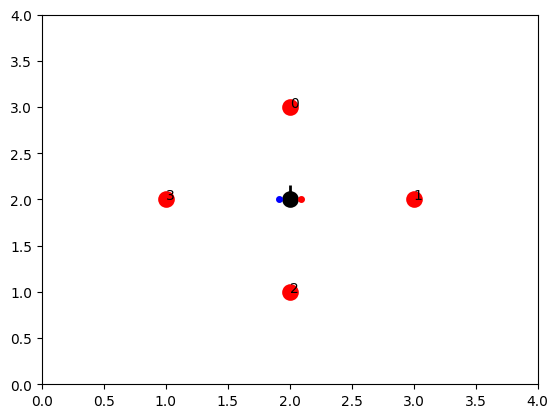

In [3]:
# --------------- DESIGN SCENE ----------------
room = np.array([4., 4., 3.]) # Room dimensions
rt60 = np.array([.2])
sources_pos= [[3., 2., 1.6], [2., 3., 1.6], [1., 2., 1.6], [2., 1., 1.6]] # Sources coordinates 
head_pos= np.array([room[0]/2, room[1]/2, 1.6]) # Listener coordinates
head_orient = np.array([0, 0]) # Head rotation
ears_pos=hlp.head_2_ku_ears(head_pos,head_orient)

# --------------- PLOT SCENE ----------------
hlp.plot_scene(room,head_pos,head_orient,ears_pos,sources_pos,perspective="xy")


In [5]:
# --------------- COMPUTE ECHOGRAMS ----------------

# some constants:
mic_specs = np.array([  [1, 0, 0, 1], [1, 0, 0, 1] ] ) #two omni mics facing to the front
fs = 16000 #sampling rate
maxlim = 2 # maximum reflection time in seconds. Stop simulating if it goes beyond that time.
ambi_order = 10 # ambisonics order
rims_d = 0.0 # displacement for Randomized Image Source method. Default is 0.

# Compute absorption coefficients for desired rt60 and room dimensions
abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60)
# Small correction for sound absorption coefficients:
if sum(rt60_true-rt60>0.05*rt60_true)>0 :
    abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60_true + abs(rt60-rt60_true))
# Generally, we simulate up to RT60:
limits = np.minimum(rt60, maxlim)

mic = np.array(ears_pos)
src = np.array(sources_pos)
nRec = mic.shape[0]
nSrc = src.shape[0]

# Compute the echograms, which means how many reflections, at what time and from which coordinates:
abs_echograms = srs.compute_echograms_sh(room, src, mic, abs_walls, limits, ambi_order, rims_d, head_orient)

Compute echogram: Source 0 - Receiver 0
Compute echogram: Source 0 - Receiver 1
Compute echogram: Source 1 - Receiver 0
Compute echogram: Source 1 - Receiver 1
Compute echogram: Source 2 - Receiver 0
Compute echogram: Source 2 - Receiver 1
Compute echogram: Source 3 - Receiver 0
Compute echogram: Source 3 - Receiver 1
Apply SH directivites
Apply absorption: Source 0 - Receiver 0
Apply absorption: Source 0 - Receiver 1
Apply absorption: Source 1 - Receiver 0
Apply absorption: Source 1 - Receiver 1
Apply absorption: Source 2 - Receiver 0
Apply absorption: Source 2 - Receiver 1
Apply absorption: Source 3 - Receiver 0
Apply absorption: Source 3 - Receiver 1


In [6]:
# --------------- RENDER ECHOGRAMS ----------------
band_centerfreqs=np.array([1000])
mic_rirs = srs.render_rirs_sh(abs_echograms, band_centerfreqs, fs)

Rendering echogram: Source 0 - Receiver 0
     Filtering and combining bands
Rendering echogram: Source 0 - Receiver 1
     Filtering and combining bands
Rendering echogram: Source 1 - Receiver 0
     Filtering and combining bands
Rendering echogram: Source 1 - Receiver 1
     Filtering and combining bands
Rendering echogram: Source 2 - Receiver 0
     Filtering and combining bands
Rendering echogram: Source 2 - Receiver 1
     Filtering and combining bands
Rendering echogram: Source 3 - Receiver 0
     Filtering and combining bands
Rendering echogram: Source 3 - Receiver 1
     Filtering and combining bands


In [7]:
# --------------- DECODE TO BINAURAL ----------------
decoder_KU100woHAinear = mat73.loadmat('ku100_inear_test.mat')['hnm']


# Load source signals:
source0, fs2 = sf.read('test1.wav')# male
source1, fs2 = sf.read('test2.wav')# child
source2, fs2 = sf.read('test3.wav')# female (rat Arthur)
source3, fs2 = sf.read('test4.wav')# female Harvard

# function to resample the signal and pick only one channel
def resampled_mono(src,fs,fs2):
    return sig.resample_poly(src[:,0] if len(src.shape)>1 else src, fs, fs2)

# create list of resampled, mono source signals
sources_sigs=[]
sources_sigs.append(resampled_mono(source0,fs,fs2))
sources_sigs.append(resampled_mono(source1,fs,fs2))
sources_sigs.append(resampled_mono(source2,fs,fs2))
sources_sigs.append(resampled_mono(source3,fs,fs2))

# set levels for all sources (this is level at the source, distance attenuation is applied by convolving with irs):
levels=[-45,-45,-45,-45] 

# generate a mixture signal with localized sources
mixture=hlp.generate_scenes(sources_sigs,levels,mic_rirs,decoder_KU100woHAinear)
Audio(mixture, rate=fs)


-45.0
-45.0
-45.0
-45.0
